# Quantum counting

Given a Boolean function $\phi: \{0,1\}^n\rightarrow \{0,1\}$, we want to count its models, i.e., the number of configurations of $n$ bits $x$ such that $\phi(x)=1$. We follow the presentation of this algorithm of Section 6.3 of

Nielsen, M., & Chuang, I. (2010). Quantum Computation and Quantum Information: 10th Anniversary Edition. Cambridge University Press.

First of all we have to include a number of packages:

In [1]:
open Microsoft.Quantum.Intrinsic;
open Microsoft.Quantum.Canon;
open Microsoft.Quantum.Convert;
open Microsoft.Quantum.Math;
open Microsoft.Quantum.Oracles;
open Microsoft.Quantum.Arithmetic;
open Microsoft.Quantum.Characterization;
open Microsoft.Quantum.Arrays;

Let us consider an example function for which we want to count its model: we have three Boolean variables, $S$, $R$, $W$ representing propositions "the sprinkler was on", "it rained last night" and "the grass is wet", respectively. We know that: if the sprinkler was on, the grass is wet ($S\rightarrow W$); if it rained last night, the grass is wet ($R\rightarrow W$); and  the sprinkler being on and rain last night cannot be true at the same time ($S\wedge R\rightarrow$). Transforming the formula into conjunctive normal form, we obtain the formula
$$\phi=(\neg S \vee W)\wedge(\neg R \vee W)\wedge(\neg S\vee \neg R)$$
This function has 4 models and can be computed with the circuit:

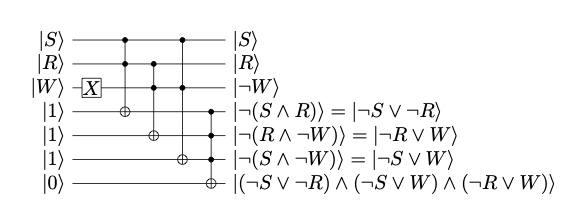

The implementation of the sprinkler circuit above is shown below:  it sets the ``target`` qubit  (the last one in the figure) if the ``q`` register makes $\phi$ true.
It is applied to a query register and a target qubit and uses three ancilla qubits. It includes an extra qubit in the query register to implement the doubling of $N=2^n$.
The operation flips the target qubit  if 
the sprinkler formula takes value 1. ``X`` is the built-in $X$ gate, ``CCNOT`` is the controlled $X$ gate with 
two control qubits, and ``Controlled X`` is a multi-controlled $X$ gate. The use of 
the ``within ... apply`` construct allows to automate uncomputation - addition of the gates that revert the operations on the query register and ancilla bits in order to properly implement the classical computation as a quantum oracle.


In [2]:
operation Sprinkler(q : Qubit[],  target : Qubit) : Unit is Adj+Ctl 
{
    use a = Qubit[3];
    within {
        X(q[2]);
        X(a[0]);
        X(a[1]);
        X(a[2]);
        CCNOT(q[0], q[1], a[0]);
        CCNOT(q[1], q[2], a[1]);
        CCNOT(q[0], q[2], a[2]);
    } apply {
        Controlled X(a + [q[3]], target);
    }
}

Sprinkler

$\newcommand{\ket}[1]{\left|{#1}\right\rangle}\newcommand{\bra}[1]{\left\langle{#1}\right|}$Operation ``ApplyMarkingOracleAsPhaseOracle``, shown below, takes as input a marking oracle (an oracle that flips the state of the target qubit) and
a register of qubits, and transforms the marking oracle into a phase oracle (an oracle that flips the sign of the register).
The $X$ and $H$ gates applied to the target qubit put it into the state $\ket{-}=(\ket{0}-\ket{1})/\sqrt{2}$, then the marking oracle is applied. Since the target is in the $\ket{-}$ state,
flipping the target if the register satisfies the oracle condition will bring the target to $-\ket{-}=-(\ket{0}-\ket{1})\sqrt{2}$, applying a $-1$ factor to the whole register, effectively applying the phase oracle.


In [3]:
operation ApplyMarkingOracleAsPhaseOracle(markingOracle : ((Qubit[], Qubit) => Unit is Adj+Ctl),  q : Qubit[]) :  Unit is Adj+Ctl 
{   
    use target = Qubit();
    within {
        // Put the target into the |-⟩ state
        X(target);
        H(target);
    } apply {
        // Apply the marking oracle; since the target is in the |-⟩ state,
        // flipping the target if the register satisfies the oracle condition will apply a -1 factor to the state
        markingOracle(q, target);
    }
}

ApplyMarkingOracleAsPhaseOracle

Operation ``GroverIteration``, shown below, takes as input a register and a marking oracle and implements
the  Grover operator $G$:
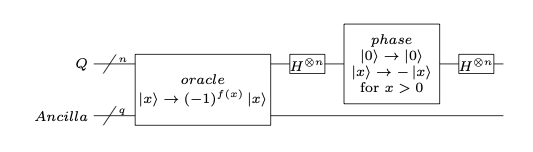
First it uses ``ApplyMarkingOracleAsPhaseOracle`` to apply the phase oracle to the register.
Then it applies $H$ to all register qubits and multiplies by $-1$ all basis states except $\ket{00\ldots0}$.
This is performed by multiplying by $-1$ only configuration $\ket{00\ldots0}$  and then rotating the register by $\pi$ radians.


In [5]:
operation GroverIteration(q : Qubit[], oracle : ((Qubit[],Qubit) => Unit is Adj+Ctl)) : Unit is Ctl+Adj
{
    ApplyMarkingOracleAsPhaseOracle(oracle, q);
    within {
        ApplyToEachCA(H, q);    // Brings |0..0⟩ to |1..1⟩
        ApplyToEachCA(X, q);    // Brings |0..0⟩ to |1..1⟩
    } apply {
        use a = Qubit();
        Controlled X(q, a);     // Bit flips the a to |1⟩ if register is |1...1⟩ 
        Z(a);                   // The phase of a (and therefore the whole register phase) becomes -1 if above condition is satisfied
        Controlled X(q, a);     // Puts a back in |0⟩ 
        Ry(2.0 * PI(), q[0]);
    }
} 

GroverIteration

Finally, operation ``Counting``, shown below, implements the whole counting algorithm:
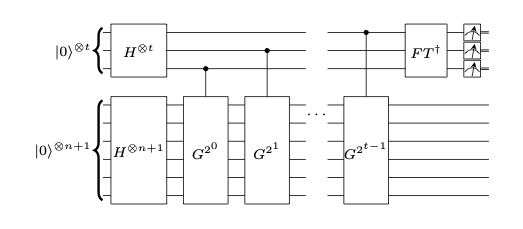
First it defines a constant ``t`` -- the number of bits to use to represent the phase.
It uses a four-qubit register for storing the state and a ``t``-qubit register for storing the phase.
It calls the ``OracleToDiscrete`` library function to convert the Grover operator to a library type ``DiscreteOracle``, suitable for exponentiation.
Then it initializes the qubits of the register applying ``H`` to each qubit.
Next, the code calls a library operation to perform quantum phase estimation.
Then we measure the phase register to get an integer divided it by $2^t$ to obtain a number between 0 and 1, the phase $\varphi$ of the eigenvalue $e^{2\pi i \phi}$ of the Grover operation. The angle of rotation that is applied by the Grover operation is then $\theta=2\pi \varphi$ and the model count is given by
$$M=2N\sin^2\theta/2$$
where in our case $n=3$, $N=2^n=2^3$


In [6]:
operation Counting() : Double 
{
    let n = 5;
    let oracle = OracleToDiscrete(GroverIteration(_, Sprinkler(_, _)));

    use (q, p) = (Qubit[4], Qubit[n]);
    ApplyToEachCA(H, q);
    // Allocate qubits to hold the eigenstate of U and the phase in a big endian register 
    let pBE = BigEndian(p);
    // Call library
    QuantumPhaseEstimation(oracle, q, pBE);
    // Read out the phase
    let phase = IntAsDouble(MeasureInteger(BigEndianAsLittleEndian(pBE))) / IntAsDouble(1 <<< (n));

    ResetAll(q + p);
    // The phase returned by QuantumPhaseEstimation is the value phi such that
    // e^{2pi phi} is an eigenvalue
    let angle = 2.0 * PI() * phase; 
    let n_sol =PowD(Sin(angle / 2.0), 2.0)*PowD(2.0,4.0);

    return n_sol;
}

Counting

The number of models of the sprinkler formula is 4 so we should obtain a number close tho 4.

In [7]:
%simulate Counting

3.5554381358431852